# Notebook 01 - Ejemplos sobre distancias

In [ ]:
import numpy as np
import tensorflow as tf # Solamente lo utilizamos para descargar los datos
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Distancia Minkowski

Vamos a implementar la función de distancia `minkowski(vector, lista_vectores, g)` que calcule la distancia de un vector a una lista de vectores.

In [ ]:
def minkowski(vector, lista_vectores, g):

  def distancia(v1, v2):
    suma = 0.0
    for xi, xj in zip(v1, v2):
      suma += np.abs(xi - xj)**g
    return suma**(1/g)

  return [distancia(vector, v) for v in lista_vectores]

In [ ]:
def minkowski_v2(vector, lista_vectores, g):
  return (np.abs(vector[None, :] - lista_vectores)**g).sum(axis=1)**(1/g)

In [ ]:
vector = np.random.randn(5)
lista_vectores = np.random.randn(10, 5)

minkowski(vector, lista_vectores, g=2) # Distancia euclidea

[2.3050959649004756,
 3.5495686450564268,
 3.014777691943252,
 1.9940987723882788,
 3.8601884661465995,
 1.2734001114412963,
 2.6452295441985907,
 2.759659586700545,
 2.788704507569533,
 2.5820271462789623]

Comprueba que has implementado correctamente la distancia Minkowski utilizando las funciones de sklearn para compararte. La diferencia entre tu implementación y la suya debería ser prácticamente 0.

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

In [ ]:
euclidean_distances(vector[None, :], lista_vectores) - minkowski(vector, lista_vectores, g=2)

array([[ 0.00000000e+00,  0.00000000e+00,  4.44089210e-16,
        -2.22044605e-16,  0.00000000e+00,  2.22044605e-16,
         0.00000000e+00, -4.44089210e-16,  4.44089210e-16,
         0.00000000e+00]])

In [ ]:
manhattan_distances(vector[None, :], lista_vectores) - minkowski(vector, lista_vectores, g=1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## Distancia entre datos

Vamos a descargar el dataset de MNIST para hacer algunas pruebas sencillas con las distancias.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Dividimos entre 255 para que todos los atributos de la imagen estén entre 0 y 1.

In [ ]:
x_train = x_train / 255
x_test = x_test / 255

Restamos ahora la media para destacar como positivos los píxeles de la clase y el resto con valores negativos.

In [ ]:
x_train = x_train - (x_train.mean(axis=0) + 1e-16)
x_test = x_test - (x_train.mean(axis=0) + 1e-16)

Veamos el aspecto que tienen nuestros datos:

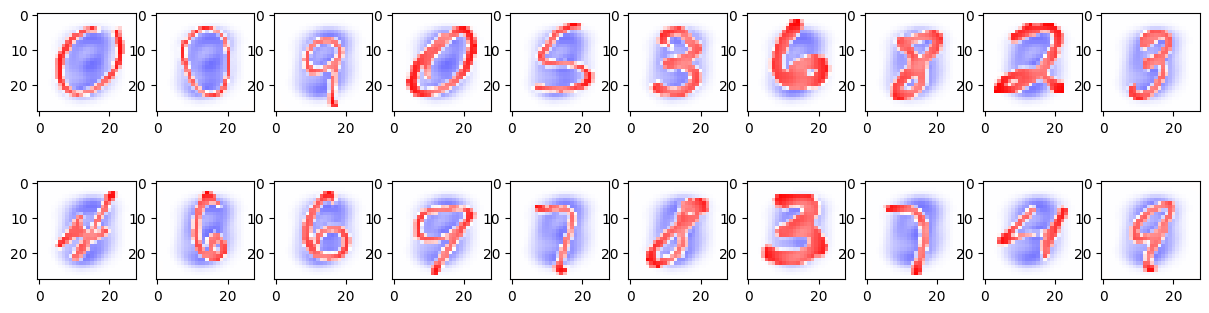

In [ ]:
plt.figure(figsize=(15,4))
for i in range(20):
  plt.subplot(2,10,i+1)
  plt.imshow(x_train[np.random.randint(60000)], cmap="bwr", vmin=-1, vmax=1)
plt.show()

Vamos a experimentar un poco con la distancia entre datos, a ver si podemos llegar a alguna conclusión interesante.

Primero, define la clase sobre la que quieres hacer pruebas:

In [ ]:
clase_target = 1

In [ ]:
x_train_clase_target = x_train[y_train == clase_target]
x_train_clase_target.shape

(6742, 28, 28)

Mostremos algunos ejemplos y seleccionemos uno:

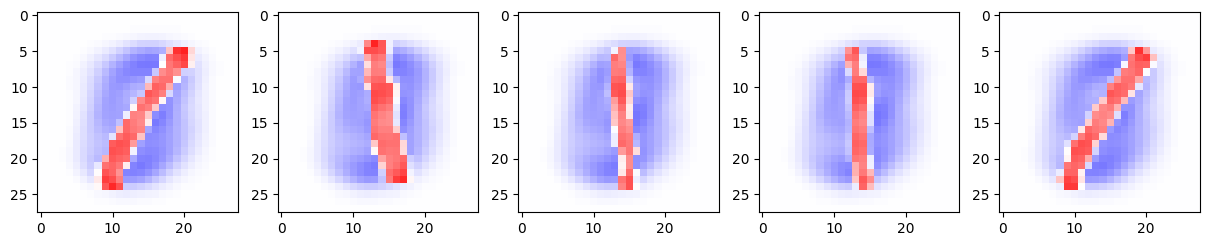

In [ ]:
plt.figure(figsize=(15,3))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(x_train_clase_target[i], cmap="bwr", vmin=-1, vmax=1)
plt.show()

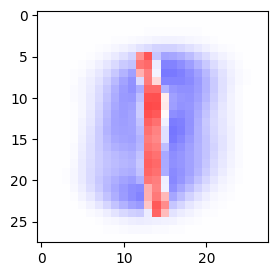

In [ ]:
imagen_objetivo = np.copy(x_train_clase_target[3])
plt.figure(figsize=(3,3))
plt.imshow(imagen_objetivo, cmap="bwr", vmin=-1, vmax=1)
plt.show()

Calculamos la distancia entre nuestra imagen objetivo y todas las demás de la clase seleccionada.

In [ ]:
distancias = minkowski_v2(imagen_objetivo.ravel(), x_train_clase_target.reshape(x_train_clase_target.shape[0], -1), g=2)
distancias.shape

(6742,)

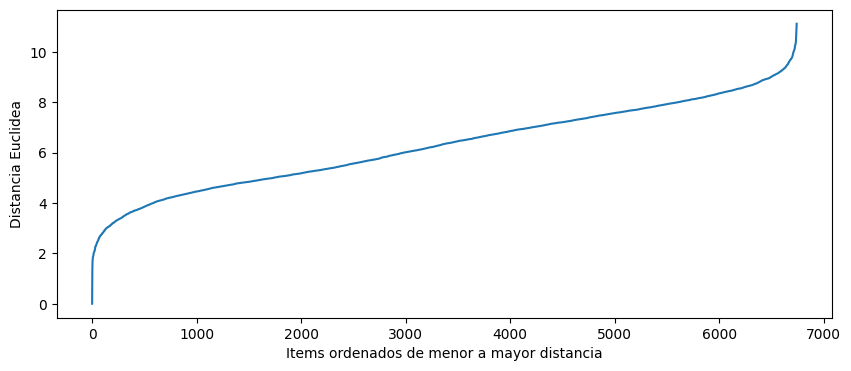

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(np.sort(distancias))
plt.xlabel("Items ordenados de menor a mayor distancia")
plt.ylabel("Distancia Euclidea")
plt.show()

Veamos cómo va modificándose el aspecto que tienen las imágenes cuanto mayor es la distancia entre ellas.

* Al principio, todas se van a parecer a la imagen objetivo.

* Más tarde, las imágenes van a ir modificándose cada vez más.

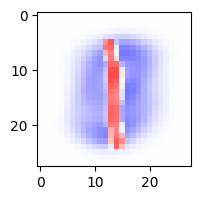

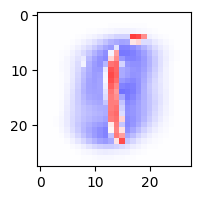

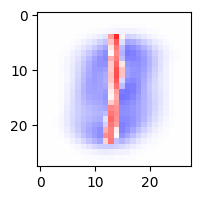

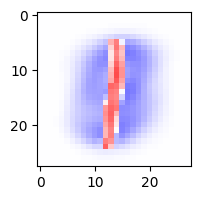

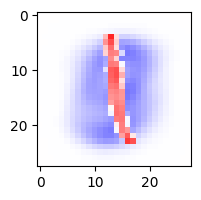

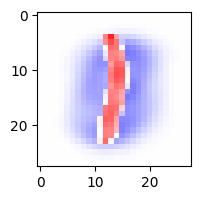

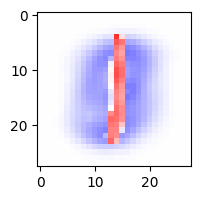

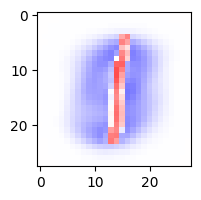

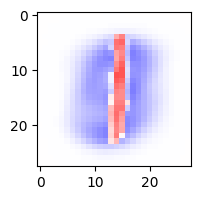

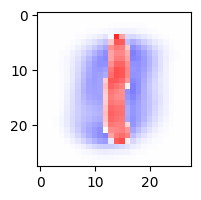

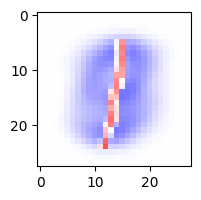

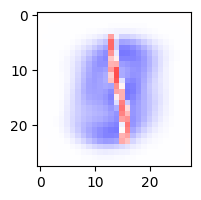

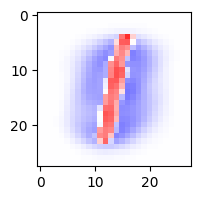

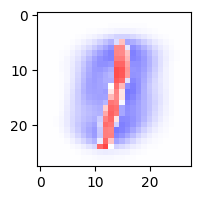

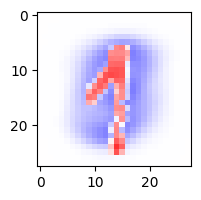

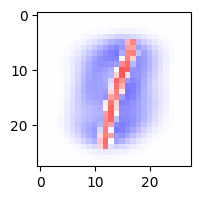

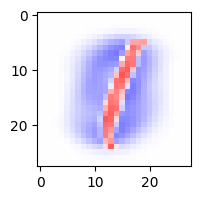

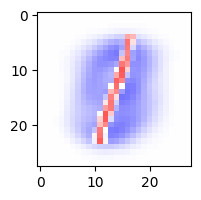

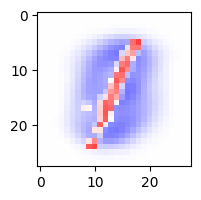

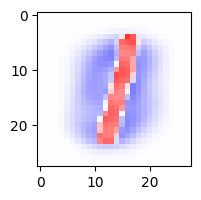

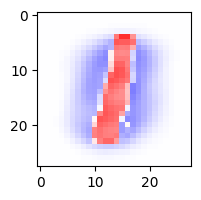

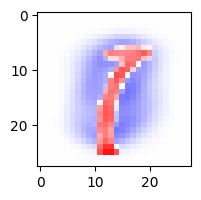

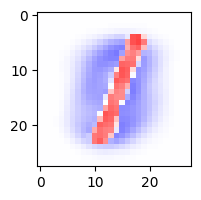

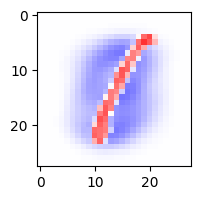

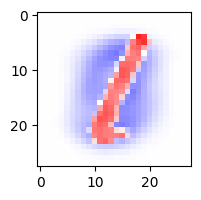

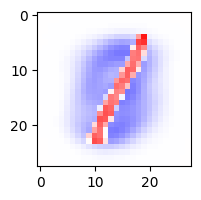

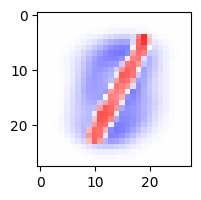

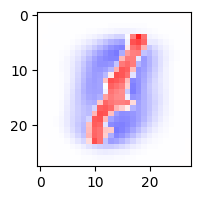

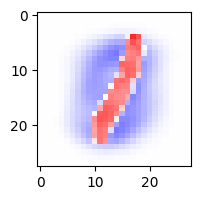

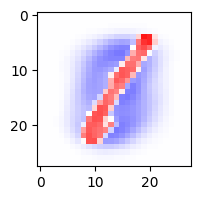

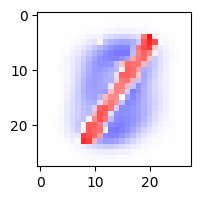

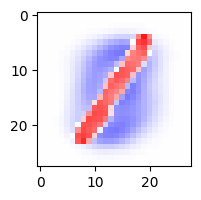

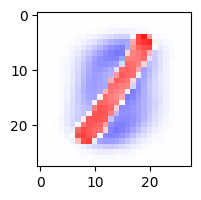

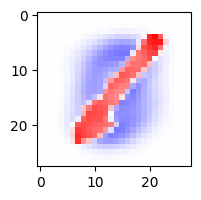

In [ ]:
distancias_sort = np.sort(distancias)
for i in range(0, len(distancias_sort), 200):
  indice_distancia = np.where(distancias == distancias_sort[i])[0][0]
  plt.figure(figsize=(2, 2))
  plt.imshow(x_train_clase_target[indice_distancia], cmap="bwr", vmin=-1, vmax=1)
  plt.show()

Hagamos lo mismo para todos los datos del dataset. Vamos a intentar construir un clasificador solamente utilizando la distancia entre los datos.

In [ ]:
distancias = minkowski_v2(imagen_objetivo.ravel(), x_train.reshape(x_train.shape[0], -1), g=2)
distancias.shape

(60000,)

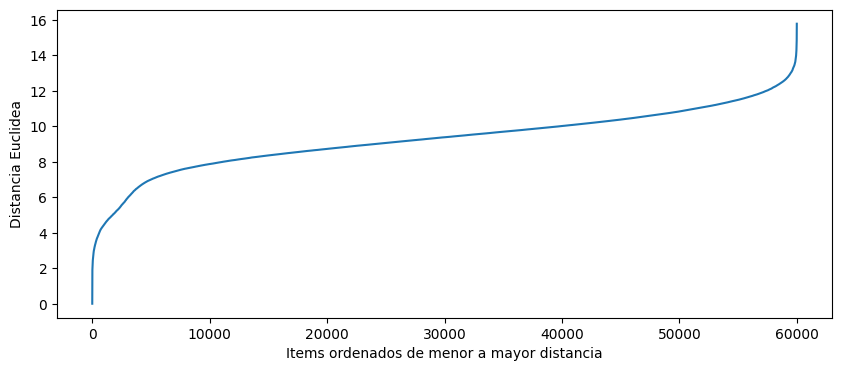

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(np.sort(distancias))
plt.xlabel("Items ordenados de menor a mayor distancia")
plt.ylabel("Distancia Euclidea")
plt.show()

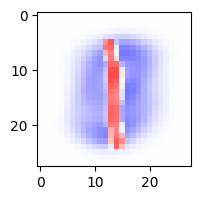

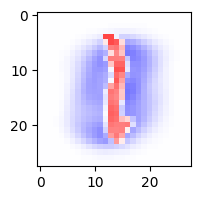

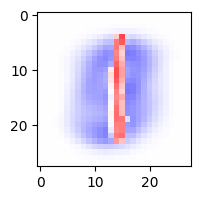

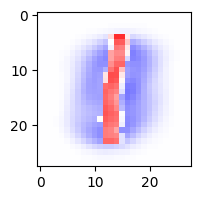

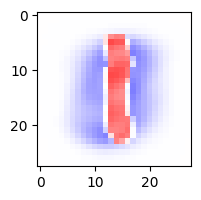

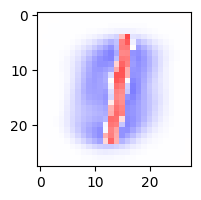

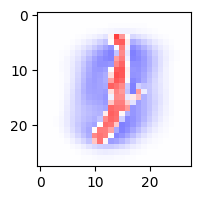

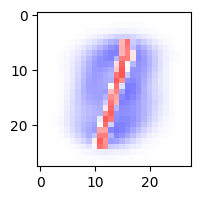

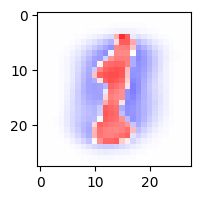

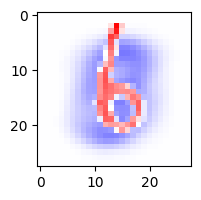

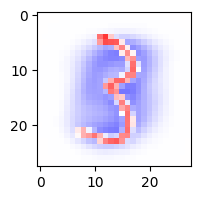

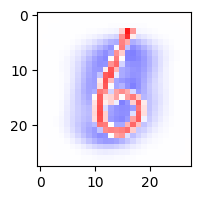

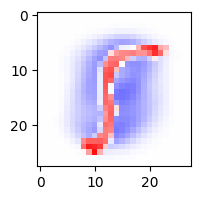

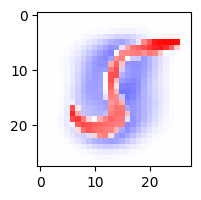

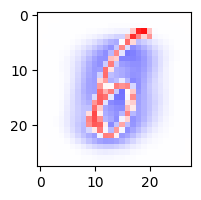

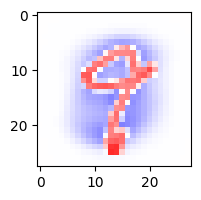

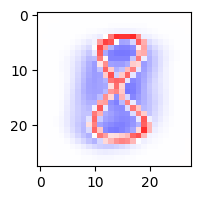

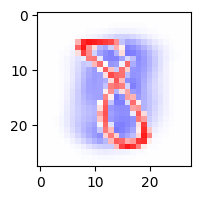

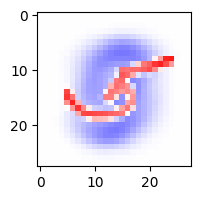

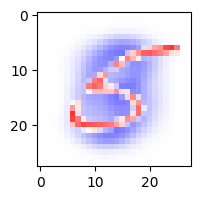

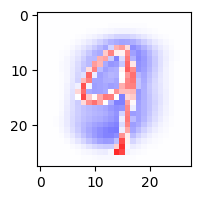

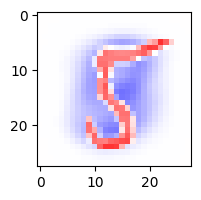

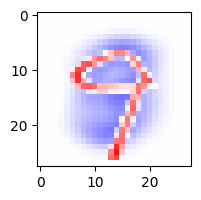

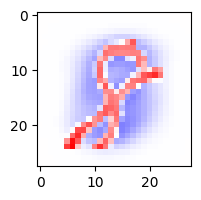

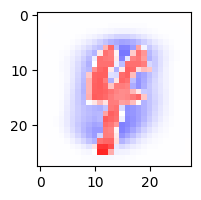

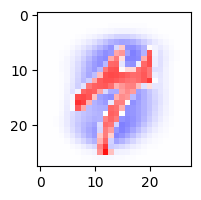

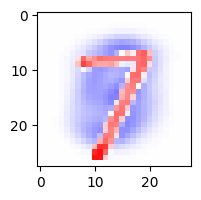

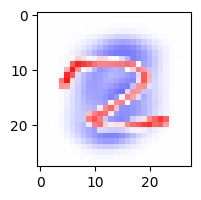

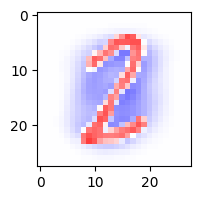

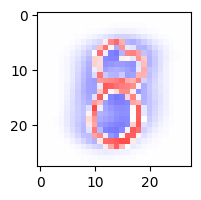

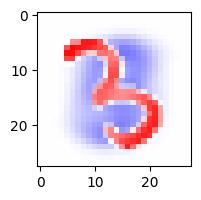

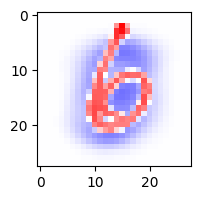

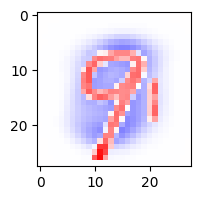

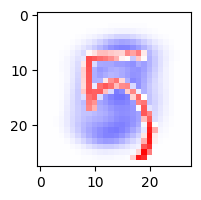

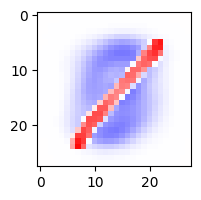

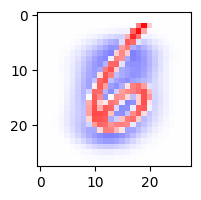

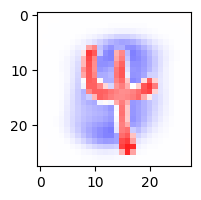

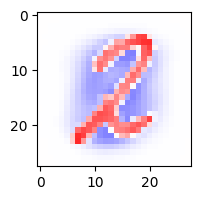

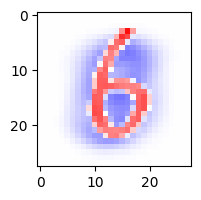

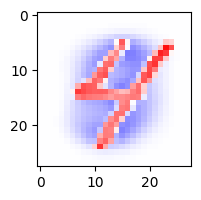

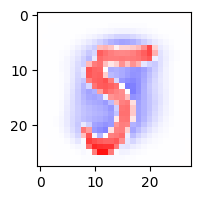

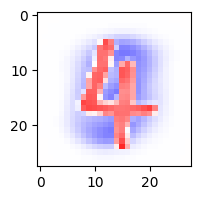

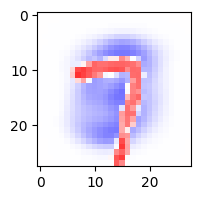

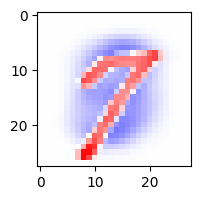

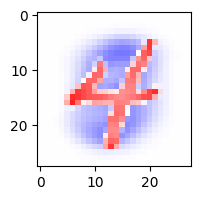

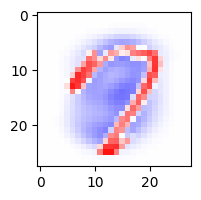

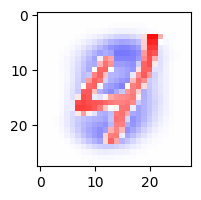

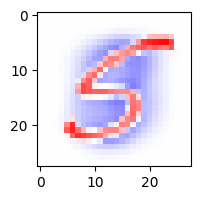

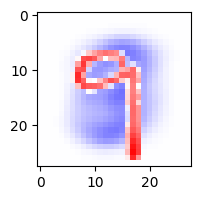

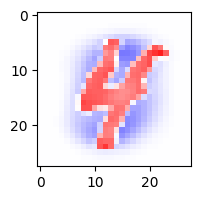

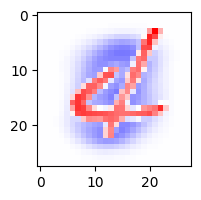

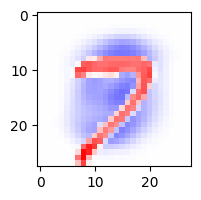

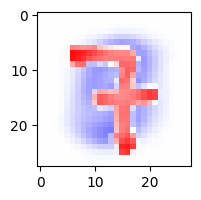

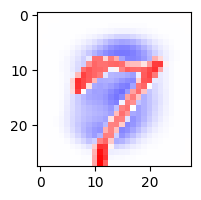

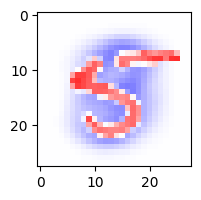

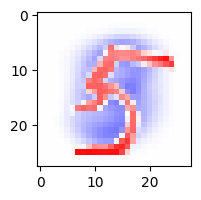

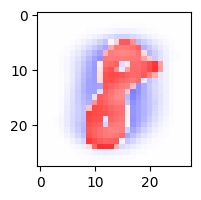

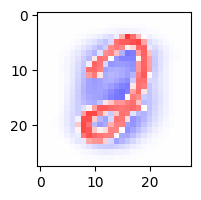

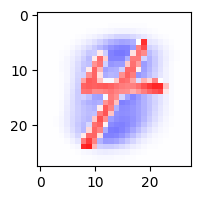

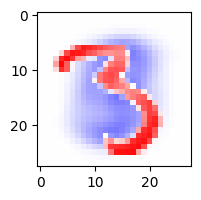

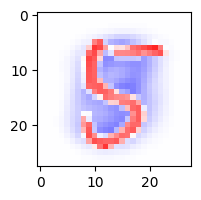

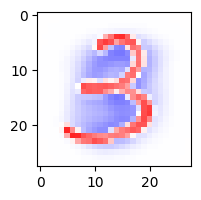

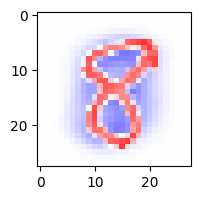

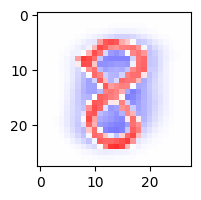

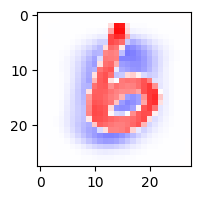

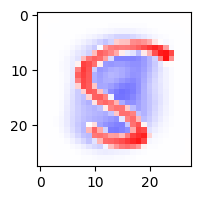

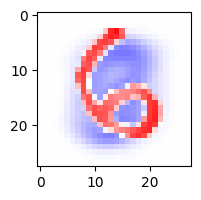

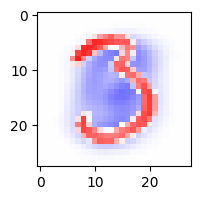

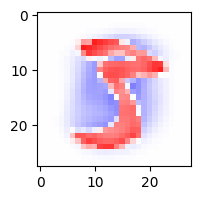

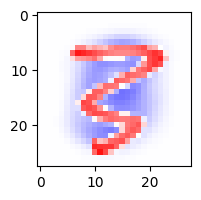

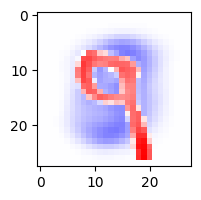

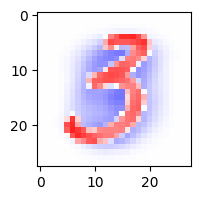

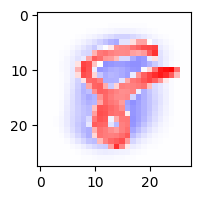

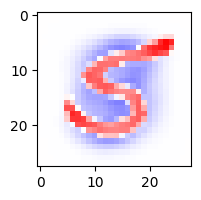

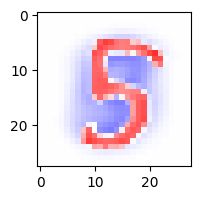

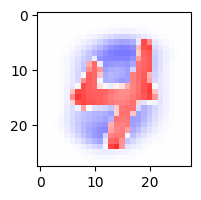

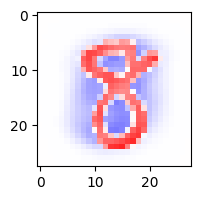

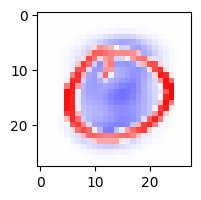

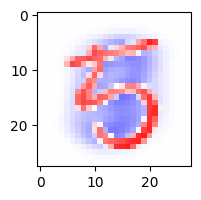

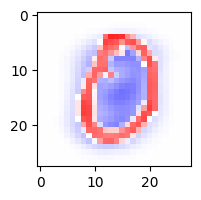

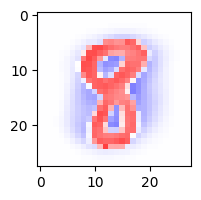

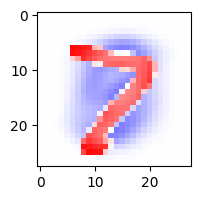

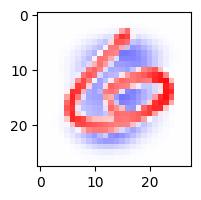

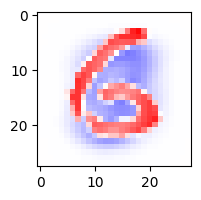

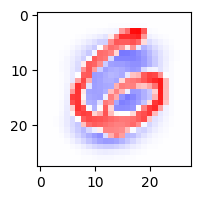

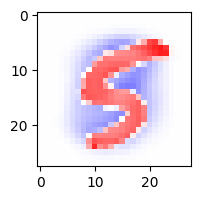

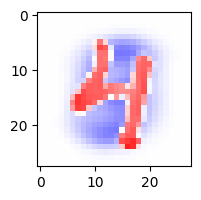

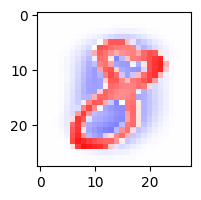

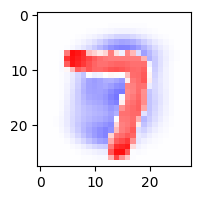

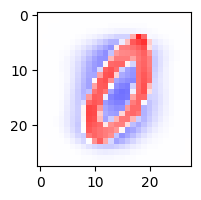

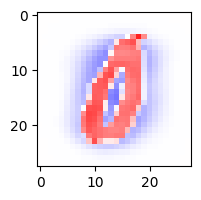

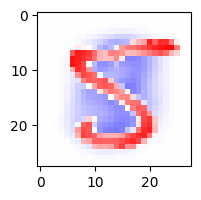

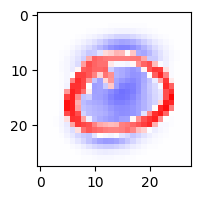

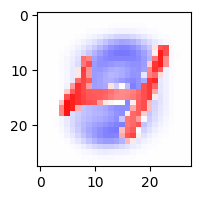

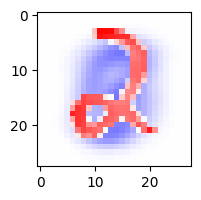

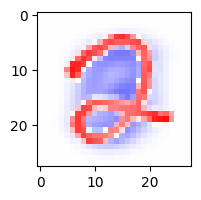

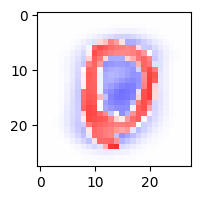

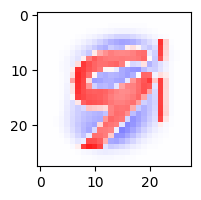

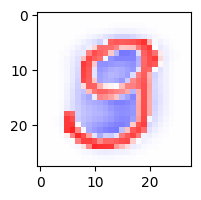

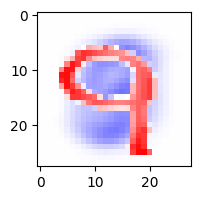

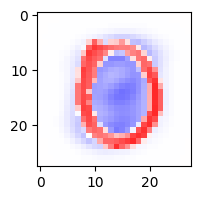

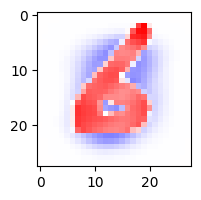

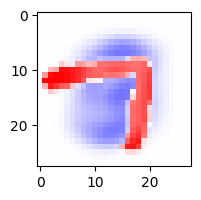

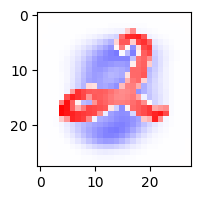

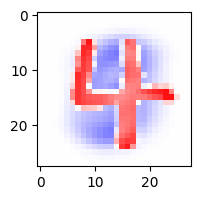

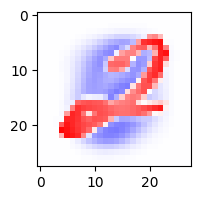

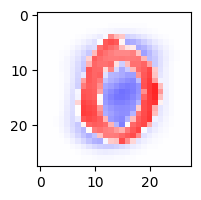

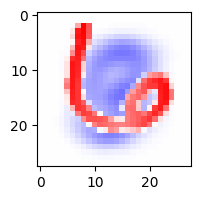

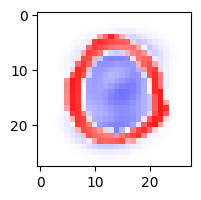

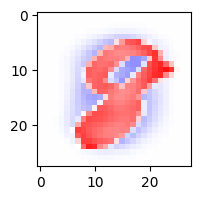

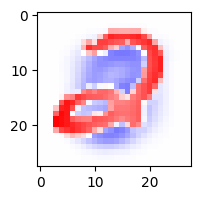

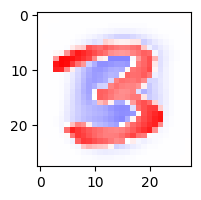

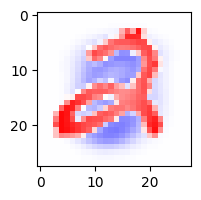

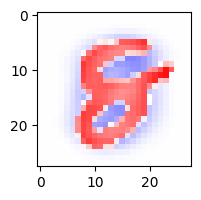

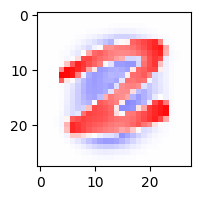

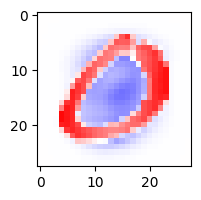

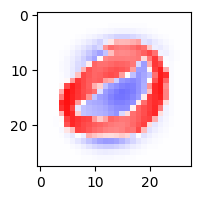

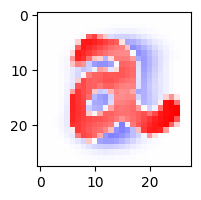

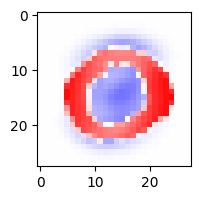

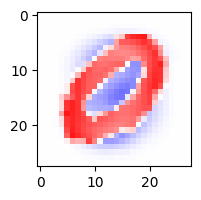

In [ ]:
distancias_sort = np.sort(distancias)
for i in range(0, len(distancias_sort), 500):
  indice_distancia = np.where(distancias == distancias_sort[i])[0][0]
  plt.figure(figsize=(2, 2))
  plt.imshow(x_train[indice_distancia], cmap="bwr", vmin=-1, vmax=1)
  plt.show()

Definamos la siguiente heurística:

1. Selecciona una distancia umbral.

2. Clasificamos de la siguiente manera:

   * Aquellos items con distancia menor que el umbral se clasifican como TRUE.

   * Aquellos items con distancia mayor que el umbral se clasifican como FALSE.

In [ ]:
N = 3000
threshold = distancias_sort[N]
pred = np.zeros_like(y_train)
# Donde la distancia sea menor que el umbral, pongo un TRUE (1.0)
pred[distancias < threshold] = 1.0

**RECORDATORIO**:

* **Accuracy**: Cuantos acierto frente al total

$$acc = \frac{TP + TN}{TP + TN + FP + FN}$$

* **Precision**: Cuántos acierto frente a los que digo que son TRUE

$$prec = \frac{TP}{TP + FP}$$

* **Recall**: De todos los TRUE, cuántos he acertado

$$recall = \frac{TP}{TP + FN}$$

* **Balanced Accuracy**: Media de los Recall de cada clase

$$bac = \frac{recall_{TRUE} + recall_{FALSE}}{2} = \frac{TPR + TNR}{2}$$

* **F1 score**: Media armónica entre precisión y recall

$$f1 = 2 \frac{precision \times recall}{precision + recall}$$

Estamos planteando una clasificación One-vs-Rest de la clase seleccionada frente al resto de clases.

In [ ]:
y_train_clase_target = y_train == clase_target

Calculamos la matriz de confusión y sacamos las métricas anteriormente mencionadas.

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_train_clase_target, pred).ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
acc = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tpr
bac = (tpr + tnr) / 2
f1 = 2 * precision * recall / (precision + recall)

print("ACCURACY:", np.around(acc, decimals=2))
print("PRECISION:", np.around(precision, decimals=2))
print("RECALL:", np.around(recall, decimals=2))
print("BALANCED ACCURACY:", np.around(bac, decimals=2))
print("F1 SCORE:", np.around(f1, decimals=2))

ACCURACY: 0.94
PRECISION: 0.98
RECALL: 0.44
BALANCED ACCURACY: 0.72
F1 SCORE: 0.6


Mostremos también la matriz de confusión:

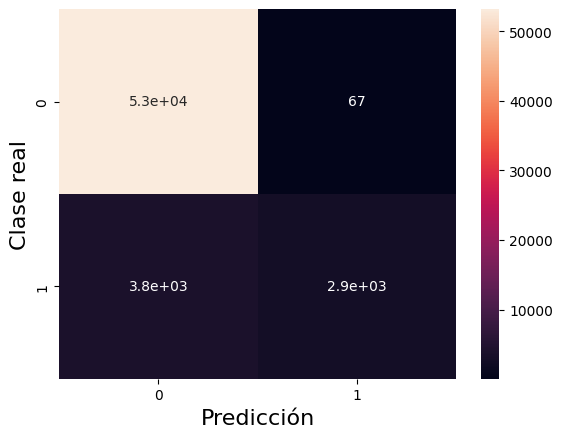

In [ ]:
sns.heatmap(confusion_matrix(y_train_clase_target, pred), annot=True)
plt.xlabel("Predicción", size=16)
plt.ylabel("Clase real", size=16)
plt.show()

## Conclusión

* Hemos aprendido a calcular la distancia Minkowski.
* Hemos visto que una simple distancia nos puede servir para obtener mucha información.
* Hemos visto que, cuanto mayor es la distancia, más diferencia hay entre el item seleccionado y la otra imagen.
* Hemos visto que las imágenes de una clase se tienen que parecer entre ellas.
* **Aún no hemos hecho clustering**